# Setup

## Imports

In [1]:
from vaiutils import path_consts, channels_last, plot_images, smooth_plot
from tqdm import tqdm_notebook
from os.path import exists
from time import sleep

In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

## Load variables and data

In [3]:
for k, v in path_consts('WGAN-GP-Paintings', 'Paintings'):
    exec(k + '=v')

In [13]:
batch_size = 64
transform = transforms.Compose(
    [transforms.Scale((64,64)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data = DataLoader(ImageFolder(DIR_DATA, transform=transform),
                  batch_size=batch_size, shuffle=True, drop_last=True)

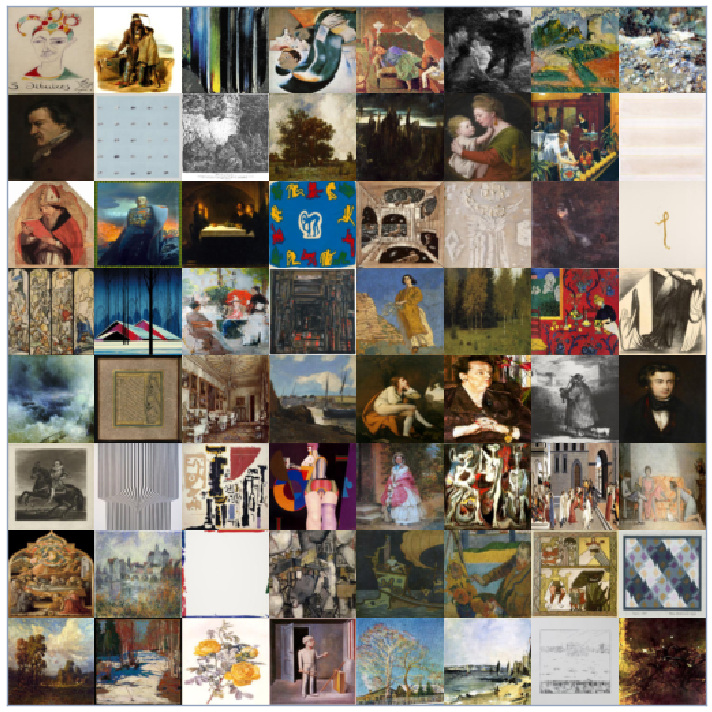

In [14]:
plot_images(channels_last(iter(data).next()[0].numpy()))

# Create Model

In [15]:
z_dim = 100
n_critic = 5
grad_lambda = 10

In [16]:
def init_weights(model):
    for m in model.modules():
        if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            nn.init.normal(m.weight.data, std=0.02)
        elif type(m) == nn.BatchNorm2d:
            nn.init.normal(m.weight.data, mean=1, std=0.02)

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(
            z_dim, 512, 4)
        self.conv2 = nn.ConvTranspose2d(
            512, 256, 4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(
            256, 128, 4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(
            128, 64, 4, stride=2, padding=1)
        self.conv5 = nn.ConvTranspose2d(
            64, 3, 4, stride=2, padding=1)
        init_weights(self)

    def relu(self, x):
        return F.relu(x, inplace=True)

    def forward(self, x):
        x = x.view(-1, z_dim, 1, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = F.tanh(self.conv5(x))
        return x

In [18]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512, 1, 4, bias=False)
        init_weights(self)

    def lrelu(self, x):
        return F.leaky_relu(x, 0.2, inplace=True)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.lrelu(self.conv4(x))
        x = self.conv5(x).squeeze()
        return x

# Train Model

In [19]:
generator = Generator().cuda()
critic = Critic().cuda()

optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
optimizer_c = optim.Adam(critic.parameters(), lr=2e-4, betas=(0.5, 0.9))

In [20]:
def save_model():
    assert(exists(DIR_OUTPUT))
    torch.save(generator.state_dict(), DIR_OUTPUT + '/generator.dat')
    torch.save(critic.state_dict(), DIR_OUTPUT + '/critic.dat')
    torch.save(history, DIR_OUTPUT + '/history.dat')


def load_model():
    if not exists(DIR_OUTPUT + '/generator.dat'):
        return
    generator.load_state_dict(torch.load(DIR_OUTPUT + '/generator.dat'))
    critic.load_state_dict(torch.load(DIR_OUTPUT + '/critic.dat'))
    history = torch.load(DIR_OUTPUT + '/history.dat')

In [21]:
history = {'loss': [], 'grad_penalty': []}


def optimize(epochs=1):
    load_model()
    for epoch in tqdm_notebook(range(max(epochs, 1))):
        for batch, datum in enumerate(tqdm_notebook(data)):
            for p in critic.parameters():
                p.require_grad = True

            x_batch = Variable(datum[0].cuda())
            z_batch = Variable(torch.randn(
                batch_size, z_dim).cuda(), volatile=True)

            x_gen = Variable(generator(z_batch).data)

            optimizer_c.zero_grad()
            loss = critic(x_batch).mean() - critic(x_gen).mean()

            a = torch.rand(batch_size, 1, 1, 1).expand_as(x_batch)
            x_hat = Variable((a * x_batch.data.cpu() + (1 - a)
                              * x_gen.data.cpu()).cuda(), requires_grad=True)
            f_x_hat = critic(x_hat)
            grads = torch.autograd.grad(f_x_hat, x_hat, grad_outputs=torch.ones(f_x_hat.size()).cuda(),
                                        create_graph=True)[0]
            grad_penalty = grad_lambda * (
                (grads.view(batch_size, -1).norm(dim=1) - 1)**2).mean()
            (grad_penalty - loss).backward()
            optimizer_c.step()

            if (batch + 1) % n_critic == 0:
                for p in critic.parameters():
                    p.require_grad = False

                z_batch = Variable(torch.randn(batch_size, z_dim).cuda())

                optimizer_g.zero_grad()
                loss_g = -critic(generator(z_batch)).mean()
                loss_g.backward()
                optimizer_g.step()

            if ((batch + 1) / n_critic) % int(100 / n_critic) == 0:
                history['loss'].append(loss.cpu().data.numpy()[0])
                history['grad_penalty'].append(
                    grad_penalty.cpu().data.numpy()[0])

            if batch % 500 == 0 or batch == len(data) - 1:
                z_batch = Variable(torch.randn(batch_size, z_dim).cuda())
                x_gen = generator(z_batch)
                plot_images(channels_last(x_gen[:5].cpu().data.numpy()))
                save_model()

            if epochs == 0 and batch == 1000:
                break
        if epochs == 0:
            break
        sleep(30)

In [25]:
DIR_OUTPUT

'/home/vaisakh/experiments/notebooks/Generative Models/GANs/output/WGAN-GP-Paintings'

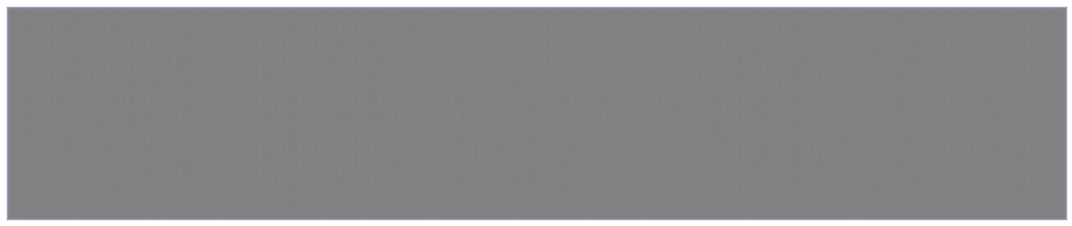

AssertionError: 

In [24]:
optimize(1)

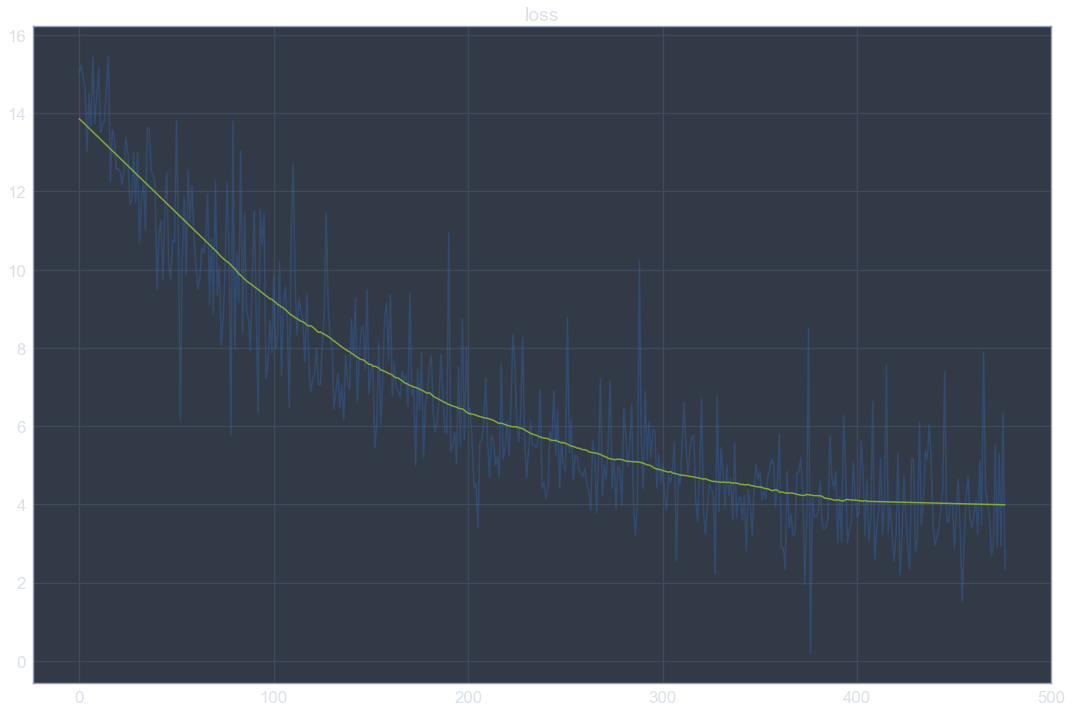

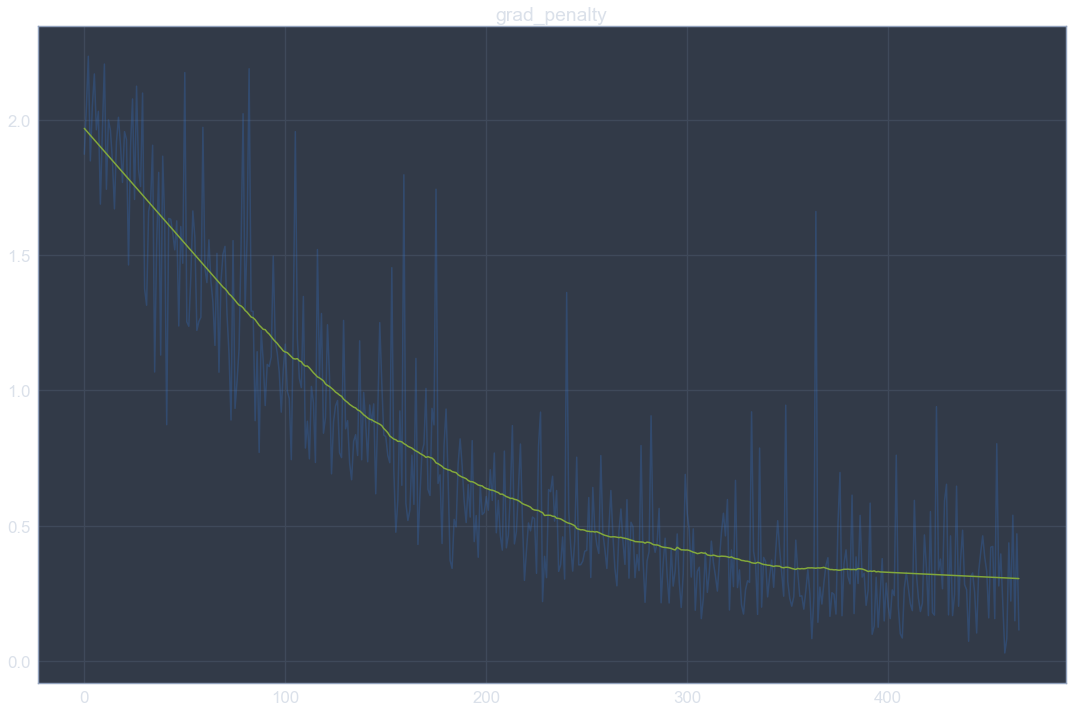

In [75]:
smooth_plot(history)

# Generate Images

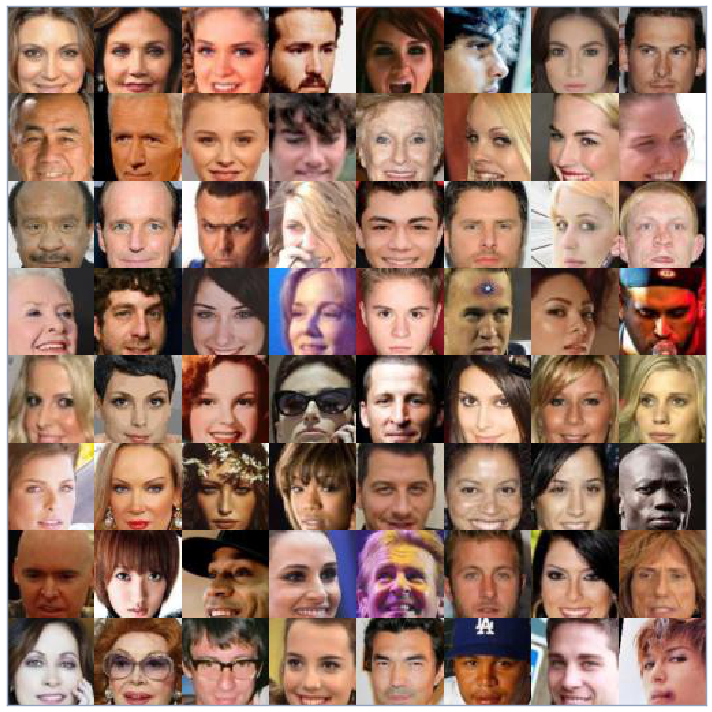

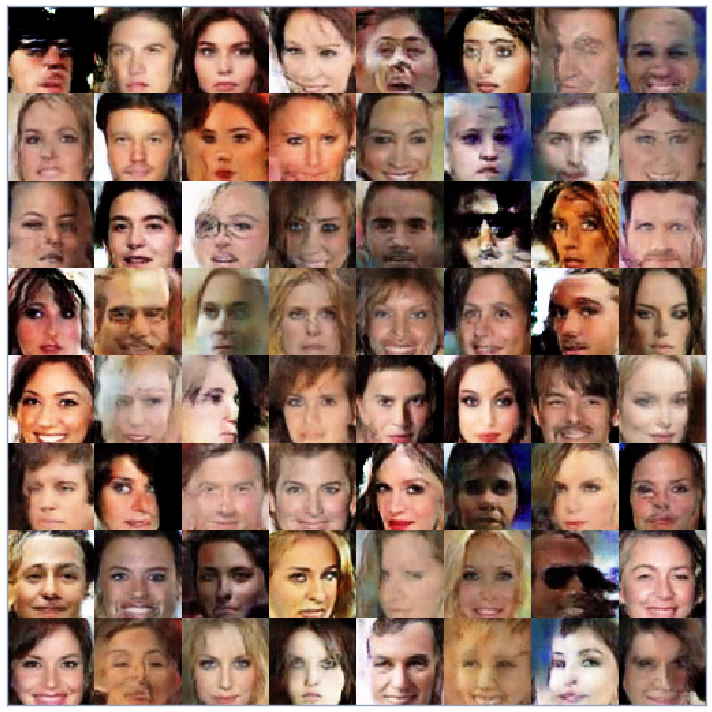

In [74]:
z_batch = Variable(torch.randn(64, z_dim).cuda(), volatile=True)
x_gen = generator(z_batch)
plot_images(channels_last(iter(data).next()[0].numpy()))
plot_images(channels_last(x_gen.cpu().data.numpy()))